In [1]:
import sys
# !{sys.executable} -m pip install shap
import lightgbm as lgb
import xgboost
import shap
from xgboost import XGBRegressor


from tqdm.notebook import trange, tqdm
from time import sleep, perf_counter

import os
from glob import glob
import pandas as pd
import numpy as np
import networkx as nx
from scipy.spatial import distance_matrix

# Scikit-learn
from sklearn.model_selection import KFold
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.preprocessing import normalize, MinMaxScaler


# Torch
import torch
print(torch.__version__,torch.__path__)
import torch.nn as nn

# Reps
from alchemical_cms import genpaddedCMs
from dscribe.descriptors import SOAP
from dscribe.kernels import REMatchKernel
from mendeleev.fetch import fetch_table
from ase.io import read
from Element_PI import VariancePersist
from Element_PI import VariancePersistv1

from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, MACCSkeys
from openbabel import openbabel as ob
from openbabel import pybel

from xyz2graph import MolGraph, to_networkx_graph

#Plotting
import seaborn as sns
sns.set_style()
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200


2.1.0 ['/Users/voglab04/miniconda3/envs/molecular_representation/lib/python3.8/site-packages/torch']
Number of monomers is equivalent to monomers+CO2: True
Using the intersection of the sets of length: 400

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [2]:
df=pd.read_excel('site_data.xlsx',index_col=0)
sitelist=['A_carboxy', 'A_amine', 'B_carboxy', 'B_amine', 'A_gly_link','B_gly_link', 'A_side', 'B_side']
inter_df=df[sitelist]
inter_df[inter_df!=0]=1


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [3]:
# Find set of files
monomerfiles=glob('./dipeptides_coordinates/AA_AA_*/final.xyz')
co2files=glob('./dipeptides_co2_coordinates/AA_AA_*/final.xyz')
# Name check
co2check=['_'.join(i.split('/')[-2].split('_')[:3]) for i in co2files]
moncheck=['_'.join(i.split('/')[-2].split('_')[:4]) for i in monomerfiles]

y=pd.read_excel('400_dipeptides_interaction_energy.xlsx',usecols=[1,2],index_col=0)
y['keypair']=['_'.join(i.split('_')[:3]) for i in y.index]
pairs=pd.DataFrame([(i[0].split(":")[0],i[0].split(":")[1].replace(" ","")) for i in pd.read_excel('400_dipeptides_interaction_energy.xlsx', 'Sheet2',header=None).values]).set_index(0)

In [4]:
AAs=list(set(sum([i[0].split('-') for i in pairs.values],[])))

In [5]:
len(AAs)

20

In [6]:
AAs

['Lysine',
 'Serine',
 'Cysteine',
 'Alanine',
 'Threonine',
 'Phenylalanine',
 'Asparticacid',
 'Proline',
 'Methionine',
 'Tryptophan',
 'Glutamine',
 'Isoleucine',
 'Tyrosine',
 'Histidine',
 'Valine',
 'Leucine',
 'Glycine',
 'Glutamicacid',
 'Arginine',
 'Asparagine']

In [7]:
ValSer=Chem.MolFromSmiles(list(pybel.readfile('xyz','./dipeptides_coordinates/AA_AA_396/final.xyz'))[0].write().split('\t')[0])

In [8]:
SerVal=Chem.MolFromSmiles(list(pybel.readfile('xyz','./dipeptides_coordinates/AA_AA_320/final.xyz'))[0].write().split('\t')[0])

In [9]:
[(u,v) for u,v in list(zip(MACCSkeys.GenMACCSKeys(ValSer).ToList(),MACCSkeys.GenMACCSKeys(SerVal).ToList())) if u!=v]

[(0, 1)]

In [10]:
DataStructs.TanimotoSimilarity(MACCSkeys.GenMACCSKeys(ValSer),MACCSkeys.GenMACCSKeys(SerVal))

0.9714285714285714

In [11]:
# img=Draw.MolsToGridImage([ValSer,SerVal],molsPerRow=2, subImgSize=(300,300))

# Draw.MolToImage(ValSer).save('ValSer.png')
# Draw.MolToImage(SerVal).save('SerVal.png')

In [12]:
pairs[pairs[1]=='Valine-Serine']

,1
0,
AA_AA_396,Valine-Serine


In [13]:
pairs[pairs[1]=='Serine-Valine']

,1
0,
AA_AA_320,Serine-Valine


In [14]:
dfpairE=pd.DataFrame(np.zeros((20,20)),index=AAs,columns=AAs)
for k,v in pairs.to_dict()[1].items():
    names=v.split('-')
    dfpairE[names[0]][names[1]]=y.set_index('keypair').loc[k].values

In [15]:
devpairs=pd.DataFrame(sum([[('-'.join((i,j)),abs(dfpairE[i][j]-dfpairE[j][i])) for idxi,i in enumerate(AAs) if idxj>idxi] for idxj,j in enumerate(AAs)],[]),columns=['Pairs','Deviation'])

In [16]:
len(devpairs[devpairs['Deviation']<=1])/len(devpairs)

0.6684210526315789

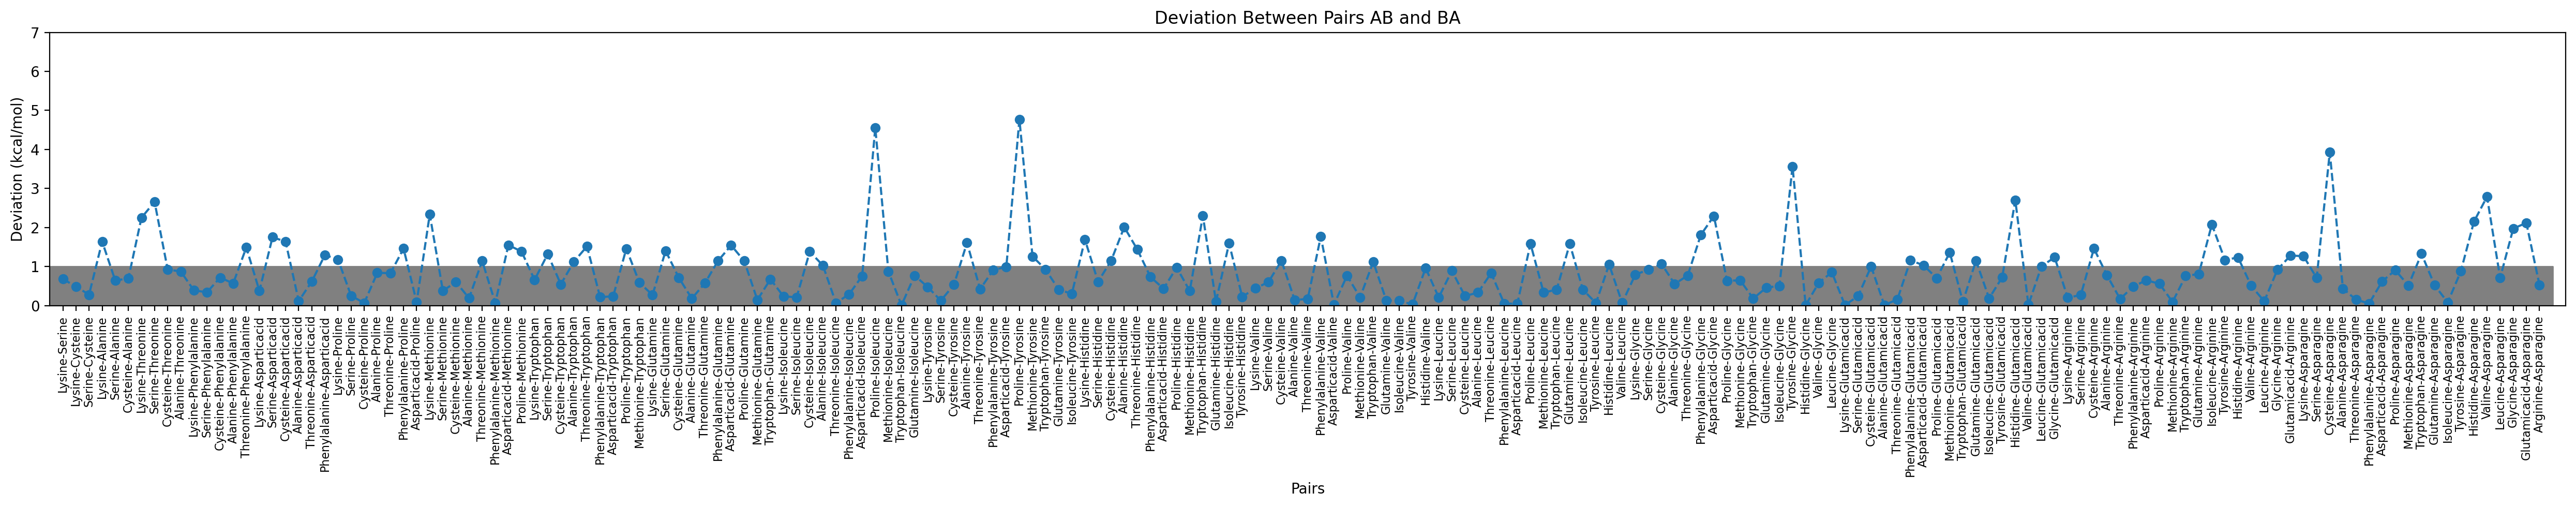

In [17]:
plt.figure(figsize=(25,5))
# sns.lineplot(data=devpairs,x='Pairs',y='Deviation')
plt.plot(range(len(devpairs['Pairs'])),devpairs['Deviation'],'o--')

plt.fill_between(np.arange(-1,len(devpairs['Pairs'])+1)*[1],np.zeros(len(devpairs['Pairs'])+2),np.ones(len(devpairs['Pairs'])+2),color='gray')
plt.xticks(range(len(devpairs['Pairs'])),devpairs['Pairs'],rotation=90, fontsize = 8)
plt.xlim(-1,len(devpairs)+1)
plt.ylim(0,7)
plt.xlabel('Pairs')
plt.ylabel('Deviation (kcal/mol)')
plt.title('Deviation Between Pairs AB and BA')
plt.tight_layout()
plt.savefig('absolute_pair_dev.png',dpi=300,bbox_inches='tight')
plt.show()

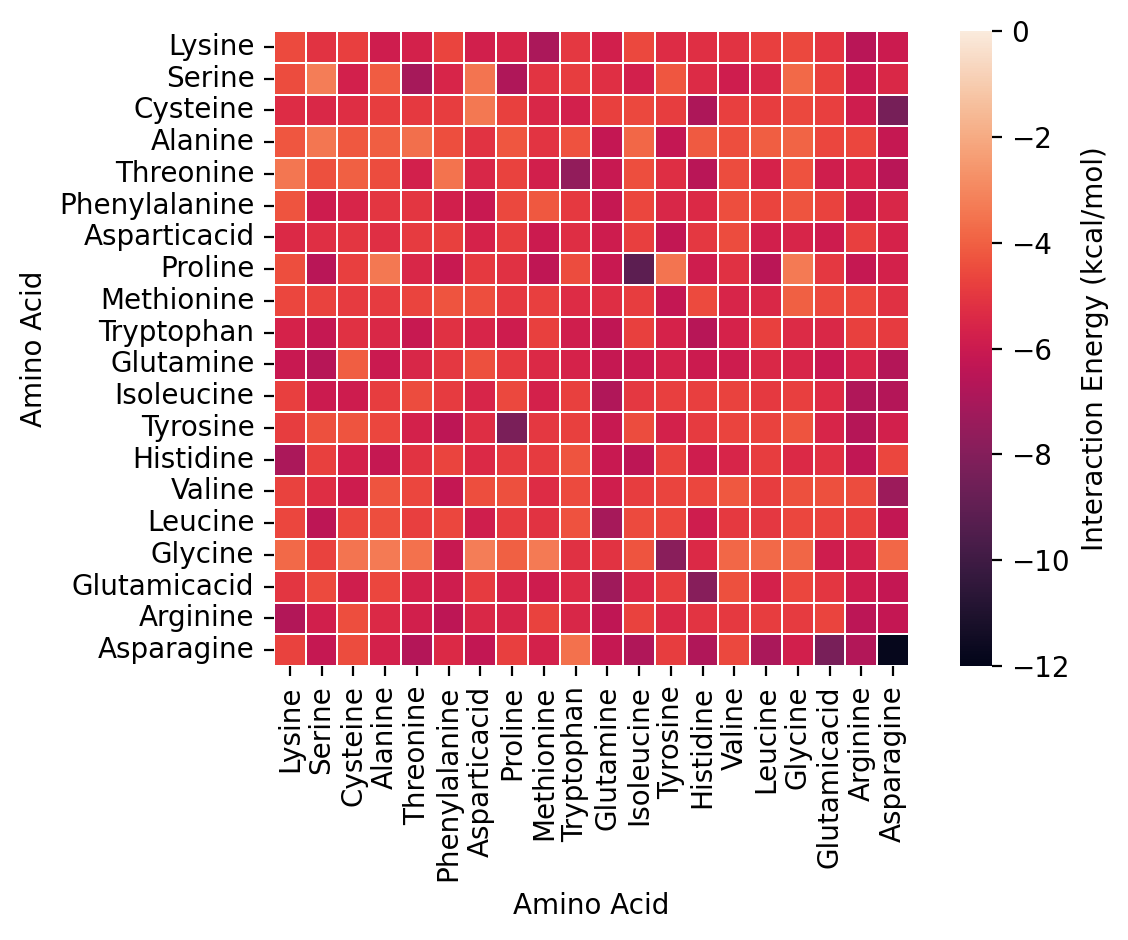

In [18]:
sns.heatmap(data=dfpairE,vmin=-12,vmax=0,cbar_kws={'label': 'Interaction Energy (kcal/mol)'},linewidths=0.1,square=True)
plt.xlabel('Amino Acid')
plt.ylabel('Amino Acid')

plt.tight_layout()
plt.savefig('pair_heat.png',dpi=300,bbox_inches='tight')
plt.show()

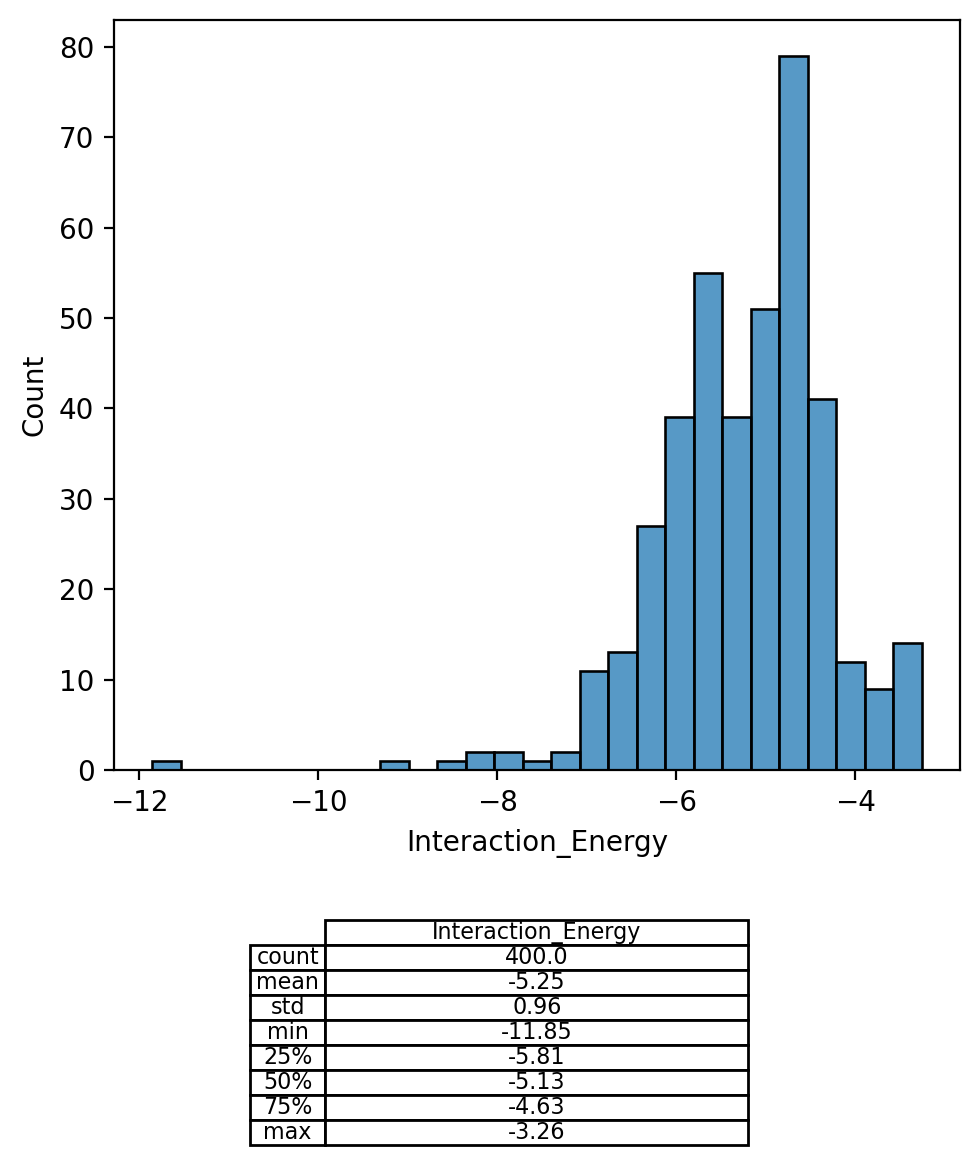

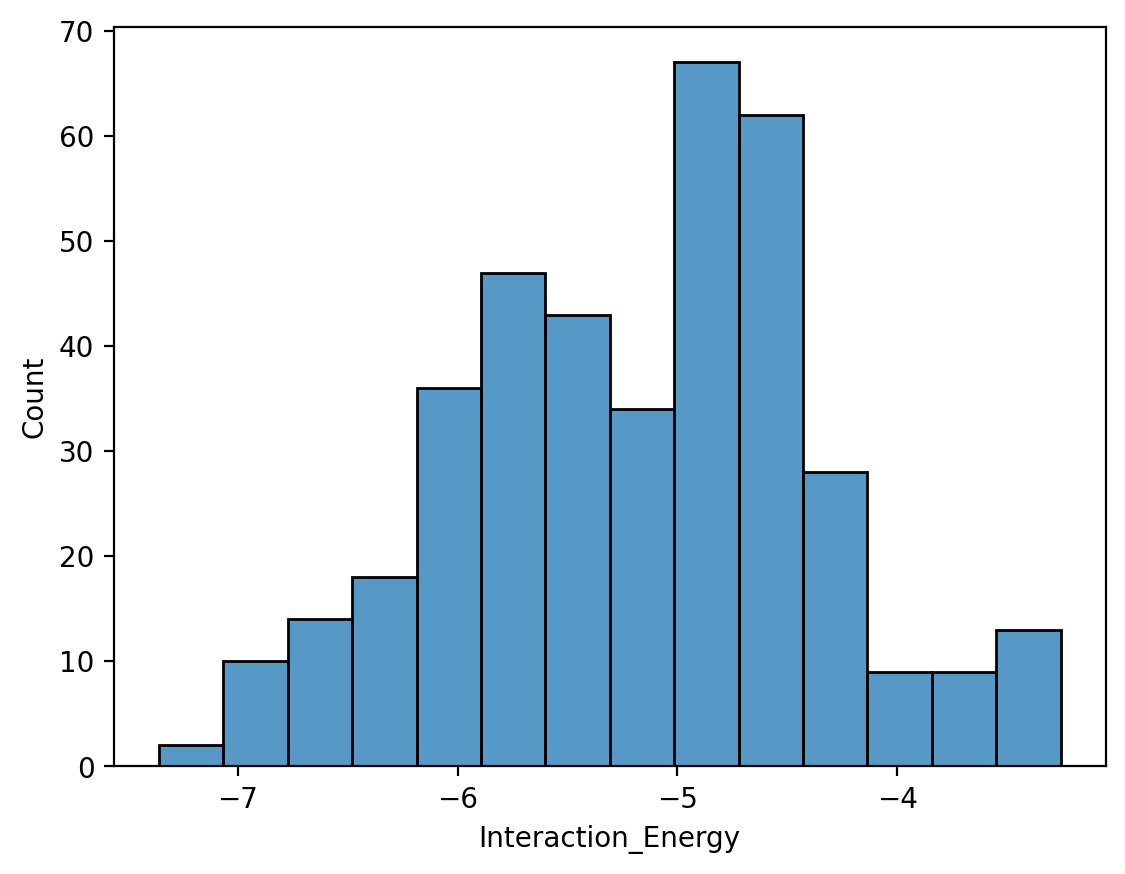

In [19]:
stats=pd.DataFrame(y['Interaction_Energy'].describe()).round(2)

plt.figure(figsize=(5,5))
sns.histplot(data=y,x='Interaction_Energy')
table =plt.table(cellText=stats.values,
          rowLabels=stats.index,
          colLabels=stats.columns,
          cellLoc = 'center', rowLoc = 'center',
          loc='bottom', bbox=[0.25, -0.5, 0.5, 0.3])


table.auto_set_font_size(False)
table.set_fontsize(8)


plt.subplots_adjust(left=0, bottom=0.5)
plt.tight_layout()
plt.savefig('spread.png',dpi=300,bbox_inches='tight')
plt.show()

Q1=y['Interaction_Energy'].quantile(0.25)
Q3=y['Interaction_Energy'].quantile(0.75)
IQR=Q3-Q1
upper = Q3 + 1.5*IQR

lower = Q1 - 1.5*IQR

y=y[(y['Interaction_Energy']>=lower)&(y['Interaction_Energy']<=upper)].dropna()
sns.histplot(data=y,x='Interaction_Energy')
plt.show()

In [20]:
bitkey=dict(zip(AAs,range(len(AAs))))

In [21]:
bitkey

{'Lysine': 0,
 'Serine': 1,
 'Cysteine': 2,
 'Alanine': 3,
 'Threonine': 4,
 'Phenylalanine': 5,
 'Asparticacid': 6,
 'Proline': 7,
 'Methionine': 8,
 'Tryptophan': 9,
 'Glutamine': 10,
 'Isoleucine': 11,
 'Tyrosine': 12,
 'Histidine': 13,
 'Valine': 14,
 'Leucine': 15,
 'Glycine': 16,
 'Glutamicacid': 17,
 'Arginine': 18,
 'Asparagine': 19}

In [22]:
# samples=len(y)
# X=np.zeros((samples,len(AAs)))
# Y=np.zeros((samples,1))

# for idx,(k,v) in enumerate(y.set_index('keypair').to_dict()['Interaction_Energy'].items()):
#     aa=pairs.loc[k].values[0].split('-')
#     a1=aa[0]
#     a2=aa[1]
#     if a1!=a2:
#         X[idx,bitkey[a1]]=1
#         X[idx,bitkey[a2]]=1
#     else:
#         X[idx,bitkey[a1]]=2
#     Y[idx]=v

In [23]:
# # Create the MolGraph object
# mg = MolGraph()

# # Read the data from the .xyz file
# mg.read_xyz(monomerfiles[0])


# # Convert the molecular graph to the NetworkX graph
# G = to_networkx_graph(mg)

# # G.nodes(data=True),G.edges(data=True)

In [24]:
# from rdkit.Chem import rdFingerprintGenerator
# mols=[Chem.MolFromSmiles(list(pybel.readfile('xyz',m))[0].write().split('\t')[0]) for m in monomerfiles]
# fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=6)

# # info={}
# # X = np.vstack([fpgen.GetFingerprint(mol) for mol in mols ])

# fps = [MACCSkeys.GenMACCSKeys(x) for x in mols]
# X=np.vstack([f.ToList() for f in fps])
# Y=y.values

# keys=pd.read_excel('MACCS_keys_example.xlsx',index_col='Key').drop(columns=['Unnamed: 0'])

# mol_keys=[idx for idx, i in enumerate(X[0]) if i==1]

# {str(keys.loc[idx].values[0]):i for idx, i in enumerate(np.count_nonzero(X,axis=0)) if i!=0}

In [25]:

# sns.heatmap([[DataStructs.TanimotoSimilarity(i,j) for i in fps] for j in fps],vmin=0,vmax=1,cmap=sns.cm.rocket_r)
# plt.show()

In [26]:
# Draw.MolsToGridImage(mols,molsPerRow=10, subImgSize=(300,300))

In [27]:
# help(Draw.MolsToGridImage)

In [28]:
stats

,Interaction_Energy
count,400.00
mean,-5.25
std,0.96
min,-11.85
25%,-5.81
50%,-5.13
75%,-4.63
max,-3.26


In [29]:
# # Intersection of the two sets
# intersection=set(['_'.join(i.split('_')[:3]) for i in list(y.index)]) & set(co2check)&set(moncheck)
# X=genpaddedCMs(intersection)
# Y=y.loc[sum([[i for i in y.index if j=='_'.join(i.split('_')[:3])] for j in intersection],[])].to_numpy().reshape(-1)

In [30]:


# ptable = fetch_table('elements').set_index('symbol')
# Z=ptable['atomic_number']

# atomLabels = {v:k for k,v in Z.to_dict().items()}

# Elementlist=list(Z.index)


# def speciescheck(files):
#     return np.unique(np.hstack([np.genfromtxt(m,skip_header=2,dtype=str,usecols=0) for m in files]))

# # species = speciescheck(foldername)
# rcut = 8.0
# nmax = 6
# lmax = 6
# species=speciescheck(monomerfiles)
# # Setting up the SOAP descriptor
# soap = SOAP(
#     species=species,
#     periodic=False,
#     rcut=rcut,
#     nmax=nmax,
#     lmax=lmax,
#     sigma=1.5
# )

# soaplist=list()



# files=glob('./dipeptides_coordinates/AA_AA_*/final.xyz')
# samples=len(y)
# Y=np.zeros((samples,1))

# for idx,i in enumerate(y.index):
#     nam='_'.join(i.split('_')[:3])
#     filename=f"./dipeptides_coordinates/{nam}/final.xyz"
#     atoms=read(filename)
#     soaplist.append(normalize(soap.create(atoms)))
#         #soaplist.append(normalize(soap.create(atoms)))
#     Y[idx,:]=y.loc[i].values
    
    

# re = REMatchKernel(metric="rbf", gamma=2, alpha=1.2, threshold=1e-8, normalize_kernel=False)
# X = re.create(soaplist)

In [31]:
# Multitarget classification 
pixelsx=150
pixelsy=150
spread=.01
Max=2.5



samples=len(df)
X=np.zeros((samples,pixelsx*pixelsy))
Y=np.zeros((samples,8))
sitelist=['A_carboxy', 'A_amine', 'B_carboxy', 'B_amine', 'A_gly_link','B_gly_link', 'A_side', 'B_side']
inter_df=df[sitelist]
inter_df[inter_df!=0]=1

for idx,(k,v) in enumerate(df['label'].to_dict().items()):
    nam='_'.join(v.split('_')[:3])
    filename=f"./dipeptides_coordinates/{nam}/final.xyz"
    if os.path.exists(os.path.join(os.getcwd(),filename)):
        X[idx,:]=VariancePersist(Filename = filename, pixelx=pixelsx, pixely=pixelsy, myspread=spread, myspecs={"maxBD": Max, "minBD":-0.1}, showplot=False)
        Y[idx,:]=inter_df.loc[k].values


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [32]:
print(X.shape,Y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print(y_train.shape,y_test.shape)

(400, 22500) (400, 8)
(280, 8) (120, 8)


In [33]:
from sklearn.linear_model import RidgeClassifier
parameters = {'alpha':np.logspace(-6,6,7)}
GridSearch = GridSearchCV(RidgeClassifier(),param_grid=parameters,cv=5,verbose=0,n_jobs=-1,scoring='r2').fit(X_train,y_train)
model=GridSearch.best_estimator_.fit(X_train,y_train)

# model=RidgeClassifier(alpha=1e-3).fit(X_train,y_train)

In [34]:
model.score(X_train,y_train),model.score(X_test,y_test)

(0.07142857142857142, 0.06666666666666667)

In [35]:
from sklearn.decomposition import PCA
pca = PCA(2)
 
#Transform the data
Y_pca = pca.fit_transform(Y)

In [36]:
from sklearn.cluster import KMeans
n_clusters=3
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(Y_pca)

In [37]:
pca_df=pd.DataFrame({'x':Y_pca[:,0],'y':Y_pca[:,1],'l':kmeans.labels_})

In [38]:
unique_clusters=np.unique(kmeans.labels_)

In [39]:
clusY=np.hstack([Y,kmeans.labels_.reshape(-1,1)])

In [40]:
uniqueY=np.unique(Y,axis=0)

In [41]:
uniqueY[0]

array([0., 0., 0., 0., 0., 0., 0., 1.])

In [42]:
groupuniq={idun:{'idx':[ridx for ridx,row in enumerate(Y) if all(uY==row)],'inter':np.array(sitelist)[uY.astype(bool)]} for idun, uY in enumerate(uniqueY)}

In [67]:
cnt_inter={k:(len(v['idx']),v['inter']) for k,v in sorted(groupuniq.items(),key=lambda x: len(x[1]['idx']))}

In [113]:
np.unique(np.array(list(cnt_inter.values()),dtype=object)[:,0].astype(int))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 19, 21, 29, 42,
       50, 58])

In [118]:
set([len(v[1]) for k,v in sorted(cnt_inter.items(),key=lambda x: len(x[1][1]))])

{1, 2, 3}

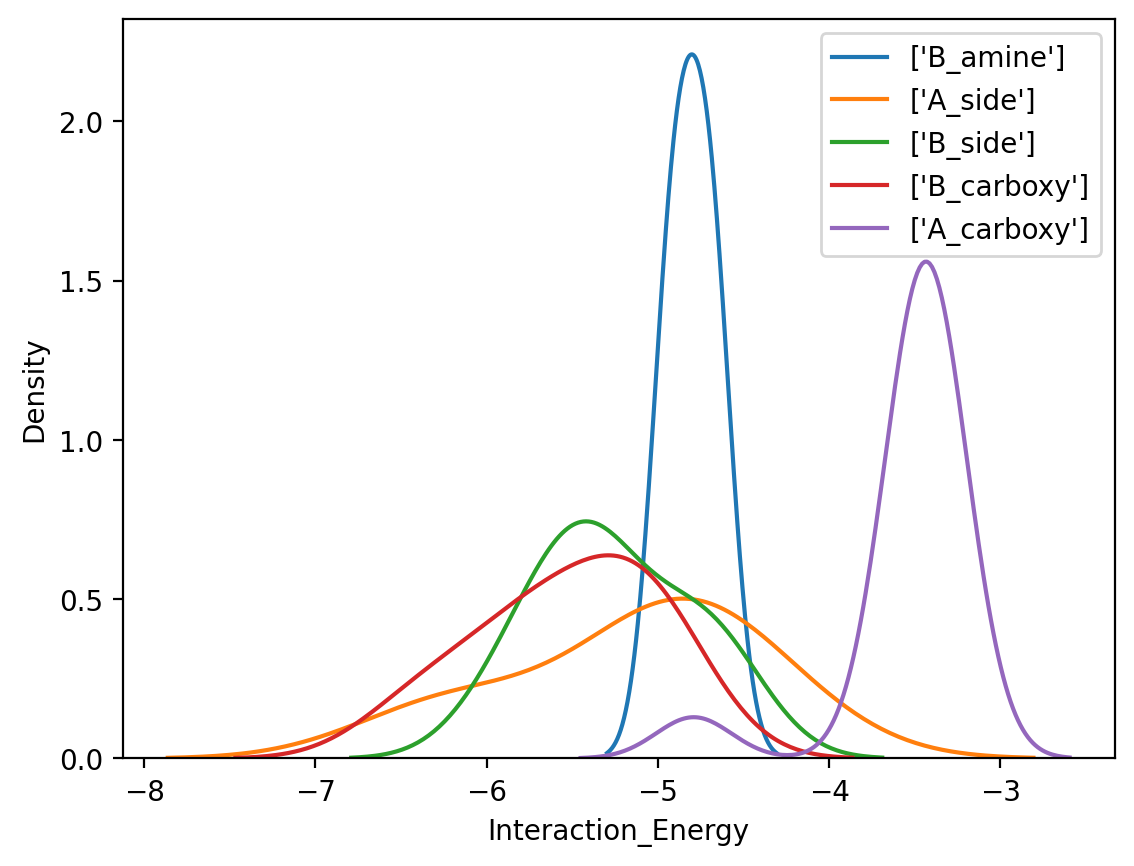

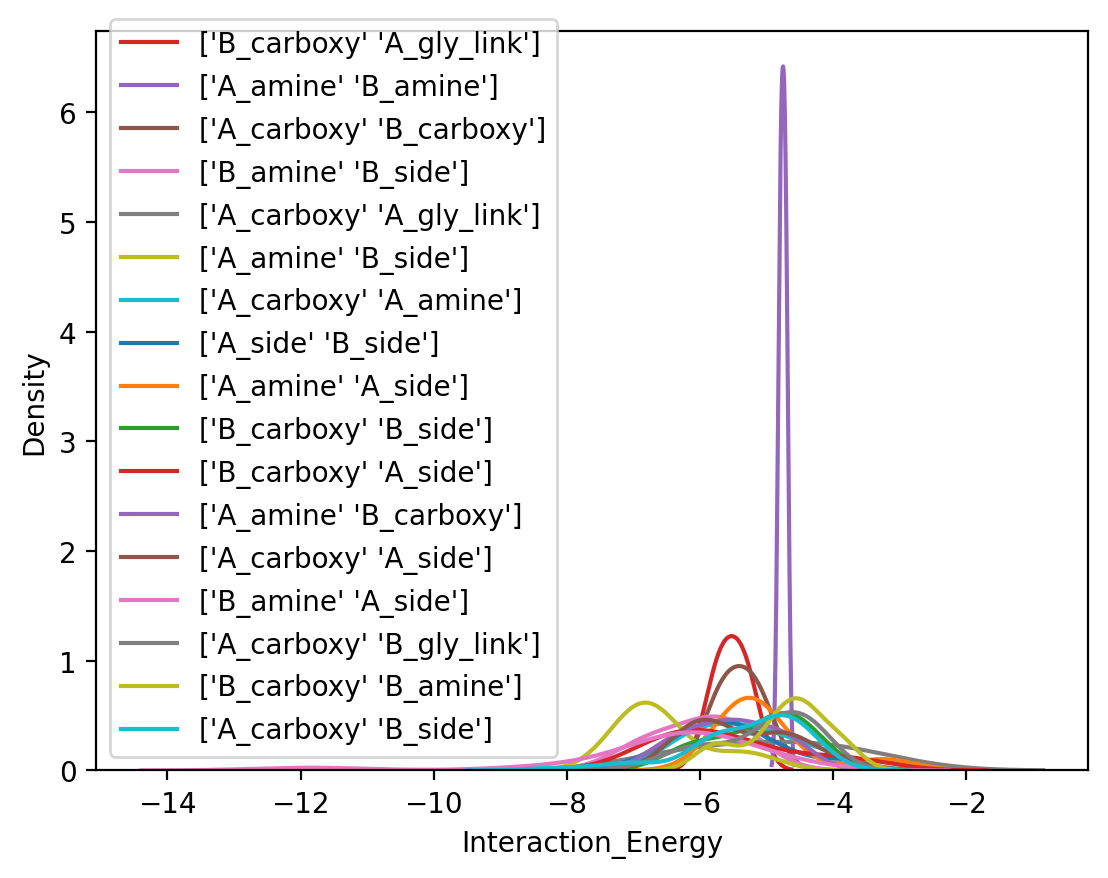

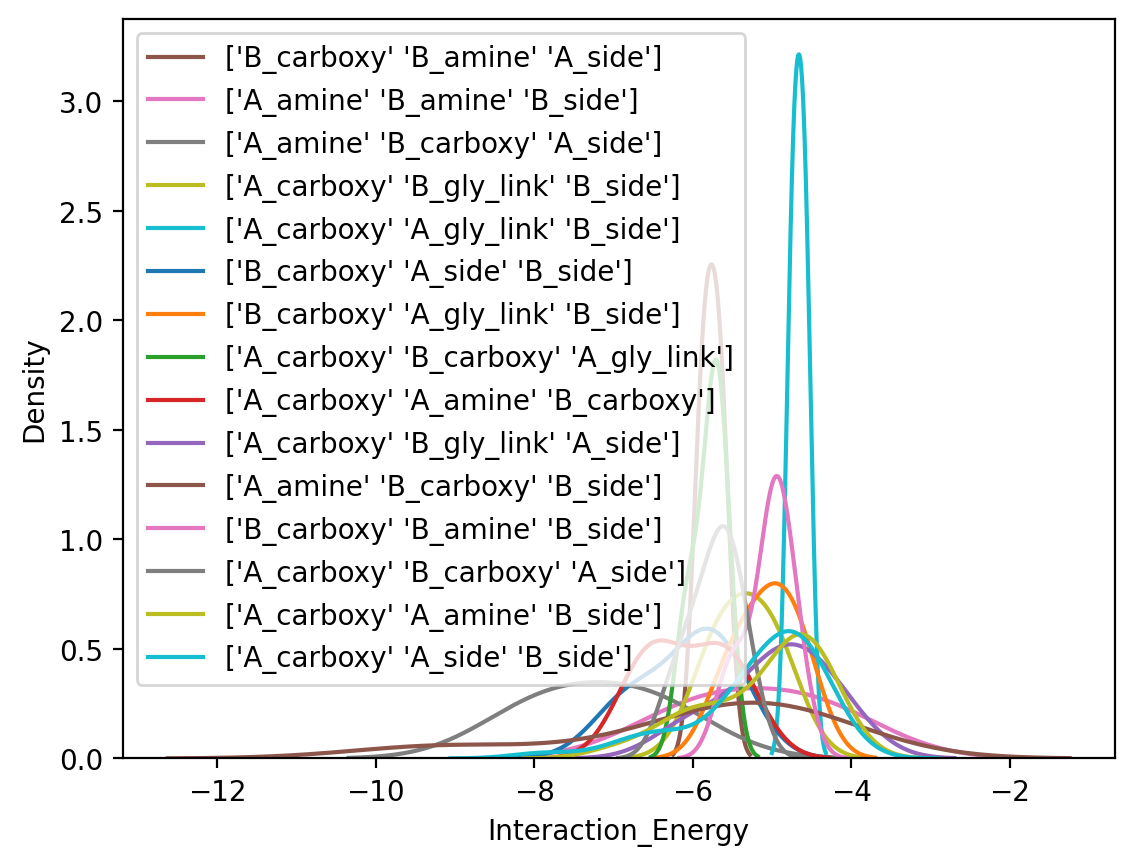

In [123]:
for i in [1,2,3]:    
    for idx, (cnt, inter) in sorted(cnt_inter.items(),key=lambda x: len(x[1][1])):
        if len(inter)==i:
            sns.kdeplot(df['Interaction_Energy'].iloc[groupuniq[idx]['idx']],label=inter,warn_singular=False)
    plt.legend()
    plt.show()

In [55]:
# cnt_inter=pd.DataFrame(np.zeros((len(sitelist),len(sitelist))),index=sitelist,columns=sitelist)

In [56]:
cnt_inter

[(1, array(['A_gly_link', 'B_side'], dtype='<U10')),
 (1, array(['A_gly_link', 'A_side', 'B_side'], dtype='<U10')),
 (1, array(['B_amine', 'A_gly_link'], dtype='<U10')),
 (1, array(['A_amine', 'A_side', 'B_side'], dtype='<U10')),
 (1, array(['A_amine', 'A_gly_link'], dtype='<U10')),
 (1, array(['A_amine', 'B_amine', 'B_gly_link'], dtype='<U10')),
 (1, array(['A_amine', 'B_carboxy', 'A_gly_link'], dtype='<U10')),
 (1, array(['A_carboxy', 'A_amine', 'B_gly_link'], dtype='<U10')),
 (2, array(['B_amine'], dtype='<U10')),
 (2, array(['B_carboxy', 'A_gly_link'], dtype='<U10')),
 (2, array(['B_carboxy', 'B_amine', 'A_side'], dtype='<U10')),
 (2, array(['A_amine', 'B_amine'], dtype='<U10')),
 (2, array(['A_amine', 'B_amine', 'B_side'], dtype='<U10')),
 (2, array(['A_amine', 'B_carboxy', 'A_side'], dtype='<U10')),
 (2, array(['A_carboxy', 'B_gly_link', 'B_side'], dtype='<U10')),
 (2, array(['A_carboxy', 'A_gly_link', 'B_side'], dtype='<U10')),
 (2, array(['A_carboxy', 'B_carboxy'], dtype='<U10'

In [65]:
sorted(cnt_inter,key=lambda x: len(x[1]))

[(2, array(['B_amine'], dtype='<U10')),
 (4, array(['A_side'], dtype='<U10')),
 (6, array(['B_side'], dtype='<U10')),
 (7, array(['B_carboxy'], dtype='<U10')),
 (14, array(['A_carboxy'], dtype='<U10')),
 (1, array(['A_gly_link', 'B_side'], dtype='<U10')),
 (1, array(['B_amine', 'A_gly_link'], dtype='<U10')),
 (1, array(['A_amine', 'A_gly_link'], dtype='<U10')),
 (2, array(['B_carboxy', 'A_gly_link'], dtype='<U10')),
 (2, array(['A_amine', 'B_amine'], dtype='<U10')),
 (2, array(['A_carboxy', 'B_carboxy'], dtype='<U10')),
 (3, array(['B_amine', 'B_side'], dtype='<U10')),
 (3, array(['A_carboxy', 'A_gly_link'], dtype='<U10')),
 (5, array(['A_amine', 'B_side'], dtype='<U10')),
 (6, array(['A_carboxy', 'A_amine'], dtype='<U10')),
 (7, array(['A_side', 'B_side'], dtype='<U10')),
 (8, array(['A_amine', 'A_side'], dtype='<U10')),
 (10, array(['B_carboxy', 'B_side'], dtype='<U10')),
 (12, array(['B_carboxy', 'A_side'], dtype='<U10')),
 (13, array(['A_amine', 'B_carboxy'], dtype='<U10')),
 (14, 

In [45]:
len(groupuniq[30])

2

In [46]:
uniqueY[30]

array([1., 0., 0., 0., 0., 0., 0., 1.])

In [47]:
df

,A_carboxy,A_amine,B_carboxy,B_amine,A_gly_link,B_gly_link,A_side,B_side,Interaction_Energy,label
Alanine-Alanine,0,0,2,1,0,0,0,0,-4.032639,AA_AA_1
Alanine-Arginine,0,0,1,1,0,0,0,1,-5.392723,AA_AA_2
Alanine-Asparagine,2,0,0,0,0,0,0,1,-5.716392,AA_AA_3
Alanine-Aspartic,2,0,0,0,0,1,0,0,-5.247079,AA_AA_4
Alanine-Cysteine,2,0,0,0,0,0,0,1,-4.872244,AA_AA_5
...,...,...,...,...,...,...,...,...,...,...
Valine-Serine,0,1,1,0,1,0,0,0,-5.861945,AA_AA_396
Valine-Threonine,1,0,0,0,0,0,1,1,-4.461757,AA_AA_397
Valine-Tryptophan,2,1,0,0,0,0,0,0,-5.625054,AA_AA_398
Valine-Tyrosine,1,1,0,0,0,0,0,1,-4.655518,AA_AA_399


In [226]:
[len(v) for k,v in sorted(groupuniq.items(),key=lambda x:len(x[1]))]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 5,
 5,
 6,
 6,
 6,
 7,
 7,
 8,
 8,
 9,
 10,
 12,
 13,
 14,
 14,
 19,
 21,
 29,
 42,
 50,
 58]

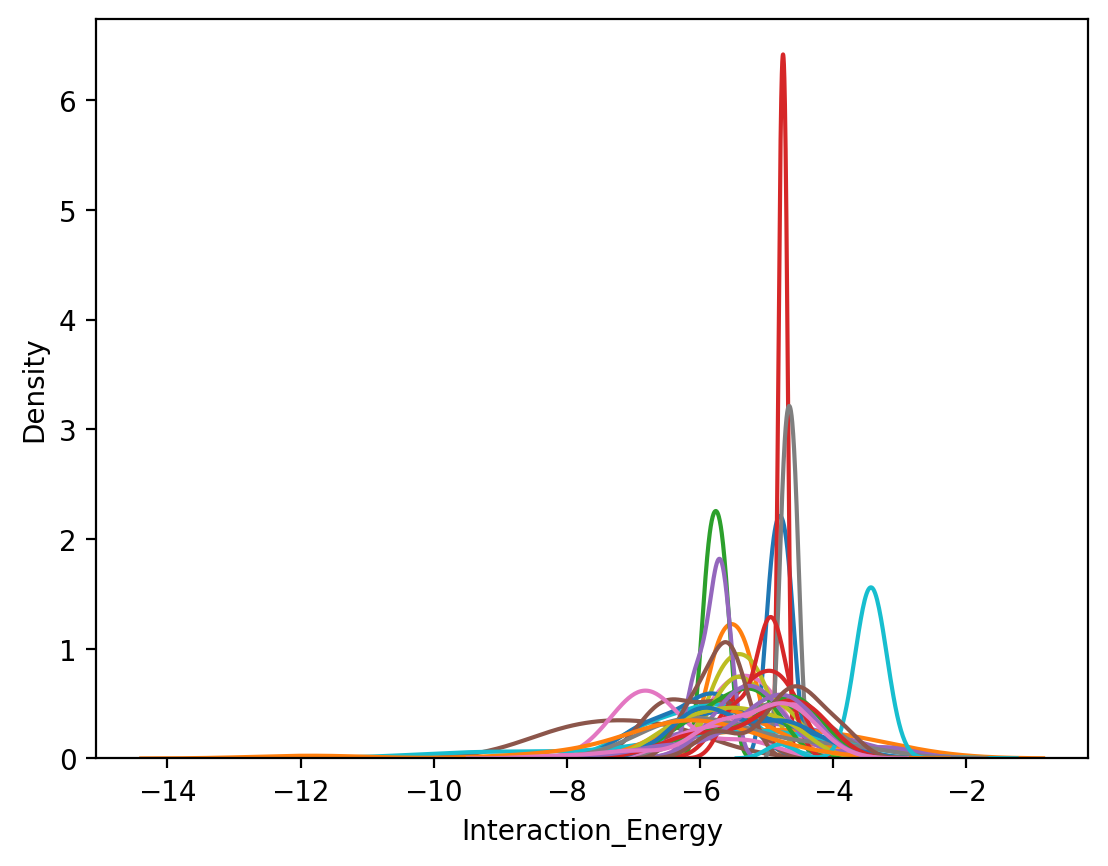

In [224]:
for k,v in sorted(groupuniq.items(),key=lambda x:len(x[1])):
    if len(v)!=1:
        sns.kdeplot(df['Interaction_Energy'].iloc[v],label=k)
plt.show()

In [174]:
uniqueY

array([[0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 1., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 1., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 1., 1.],
       [0., 0., 1., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 1., 1.],
       [0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0., 1.],
       [0., 1., 

In [42]:
sitelist

['A_carboxy',
 'A_amine',
 'B_carboxy',
 'B_amine',
 'A_gly_link',
 'B_gly_link',
 'A_side',
 'B_side']

In [43]:
df.iloc[[idx for idx, i in enumerate(clusY[:,-1]) if i==0]]['Interaction_Energy']

Alanine-Alanine         -4.032639
Alanine-Arginine        -5.392723
Alanine-Leucine         -4.406323
Alanine-Lysine          -5.896824
Alanine-Phenylalanine   -5.017300
                           ...   
Valine-Isoleucine       -4.718104
Valine-Leucine          -4.933344
Valine-Methionine       -5.545149
Valine-Proline          -5.159300
Valine-Serine           -5.861945
Name: Interaction_Energy, Length: 125, dtype: float64

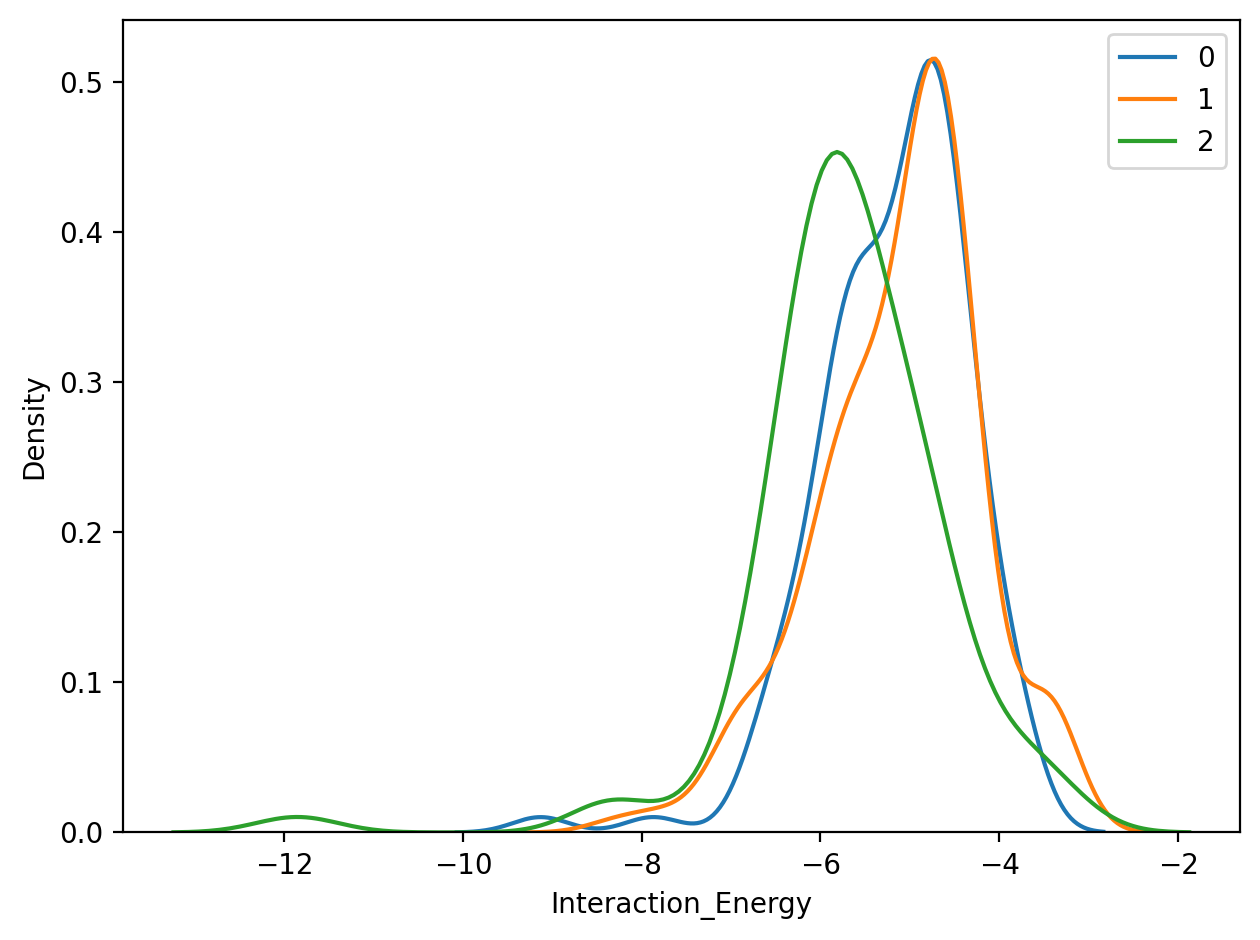

In [44]:
for c in range(n_clusters):
    sns.kdeplot(df.iloc[[idx for idx, i in enumerate(clusY[:,-1]) if i==c]]['Interaction_Energy'],label=c)
plt.legend()
plt.tight_layout()
plt.savefig(f'cluster_n{n_clusters}_kde.png',dpi=300,bbox_inches='tight')
plt.show()

In [45]:
for i in unique_clusters:
    uni=np.unique(clusY[clusY[:,-1]==i],axis=0)
    for j in uni:
        print(np.array(sitelist)[np.array(j.astype(bool)[:-1])])
    # print(uni)
    print(i,uni.shape)

['B_amine']
['B_amine' 'B_side']
['B_amine' 'A_gly_link']
['B_carboxy']
['B_carboxy' 'B_side']
['B_carboxy' 'A_gly_link']
['B_carboxy' 'A_gly_link' 'B_side']
['B_carboxy' 'B_amine']
['B_carboxy' 'B_amine' 'B_side']
['A_amine' 'A_gly_link']
['A_amine' 'B_amine']
['A_amine' 'B_amine' 'B_side']
['A_amine' 'B_amine' 'B_gly_link']
['A_amine' 'B_carboxy']
['A_amine' 'B_carboxy' 'B_side']
['A_amine' 'B_carboxy' 'A_side']
['A_amine' 'B_carboxy' 'A_gly_link']
['A_carboxy' 'B_carboxy']
['A_carboxy' 'B_carboxy' 'A_gly_link']
['A_carboxy' 'A_amine' 'B_carboxy']
0 (20, 9)
['B_side']
['A_gly_link' 'B_side']
['A_amine' 'B_side']
['A_amine' 'A_side' 'B_side']
['A_carboxy']
['A_carboxy' 'B_side']
['A_carboxy' 'A_side' 'B_side']
['A_carboxy' 'B_gly_link']
['A_carboxy' 'B_gly_link' 'B_side']
['A_carboxy' 'A_gly_link']
['A_carboxy' 'A_gly_link' 'B_side']
['A_carboxy' 'A_amine']
['A_carboxy' 'A_amine' 'B_side']
['A_carboxy' 'A_amine' 'B_gly_link']
1 (14, 9)
['A_side']
['A_side' 'B_side']
['A_gly_link' 'A_s

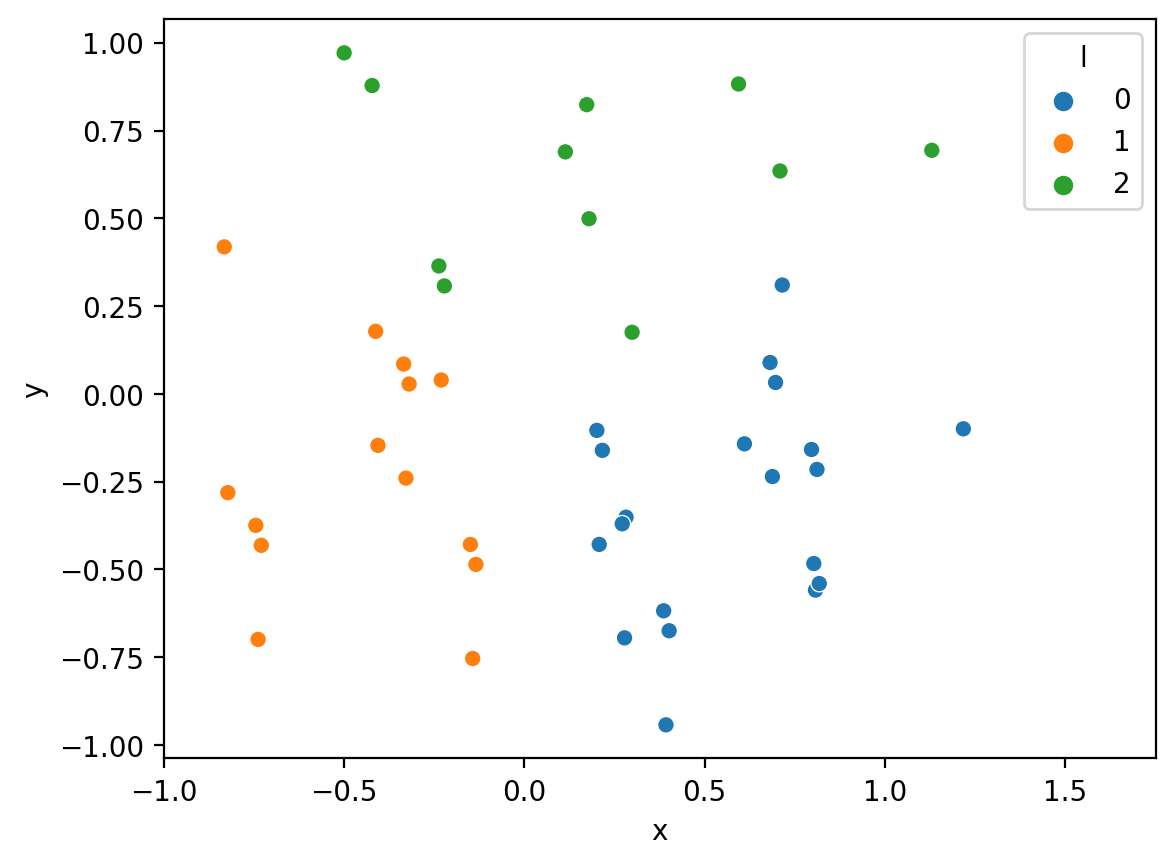

In [46]:
sns.scatterplot(data=pca_df,x='x',y='y',hue='l',palette=sns.color_palette('tab10',n_clusters))
plt.xlim(-1,1.75)
plt.savefig(f'cluster_n{n_clusters}_cluster.png',dpi=300,bbox_inches='tight')
plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(280, 2500) (120, 2500)
[ 0.1092188   0.03549333  0.01112462 -0.40831996]
Mean accuracy of -0.0631 with a standard deviation of 0.20
R2: 0.9966,-0.2154
RMSE (kcal/mol): 0.0567,1.0307


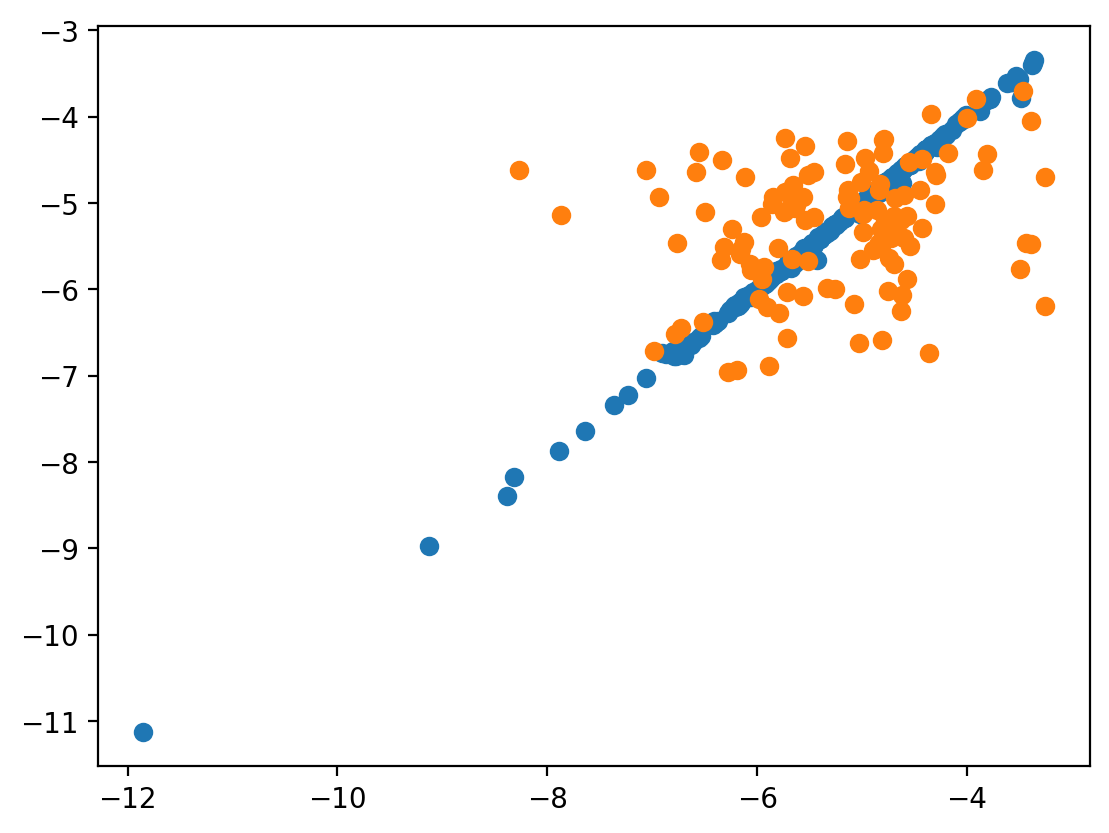

In [172]:
# Multitarget classification 
pixelsx=50
pixelsy=50
spread=.01
Max=2.5



samples=len(df)
X=np.zeros((samples,pixelsx*pixelsy))
Y=np.zeros((samples,1))

for idx,(k,v) in enumerate(df['label'].to_dict().items()):
    nam='_'.join(v.split('_')[:3])
    filename=f"./dipeptides_coordinates/{nam}/final.xyz"
    if os.path.exists(os.path.join(os.getcwd(),filename)):
        perX=VariancePersist(Filename = filename, pixelx=pixelsx, pixely=pixelsy, myspread=spread, myspecs={"maxBD": Max, "minBD":-0.1}, showplot=False)
        X[idx,:]=perX
        # X[idx,:]=np.concatenate([perX,inter_df.loc[k].values])
        Y[idx,:]=df['Interaction_Energy'].loc[k]
        
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=34)
print(X_train.shape,X_test.shape)



model=XGBRegressor(device='cpu',reg_lambda=1e-3,reg_alpha=1e-3,max_depth=10,min_child_weight=10)
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, Y, cv=4)
print(scores)
print("Mean accuracy of %0.4f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

model.fit(X_train,y_train)
y_pred_train=model.predict(X_train)
y_pred_test=model.predict(X_test)
print(f"R2: {r2_score(y_train,y_pred_train):.4f},{r2_score(y_test,y_pred_test):.4f}")
print(f"RMSE (kcal/mol): {mean_squared_error(y_train,y_pred_train,squared=False):.4f},{mean_squared_error(y_test,y_pred_test,squared=False):.4f}")
plt.scatter(y_train,y_pred_train)
plt.scatter(y_test,y_pred_test)
plt.show()

In [122]:


X=inter_df
Y=df['Interaction_Energy'].values
        
        
Y=Y.reshape(-1,)        
print(X.shape,Y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print(X_train.shape,X_test.shape)



model=XGBRegressor(device='cpu',reg_lambda=0.3,max_depth=10,min_child_weight=5)
model.fit(X_train,y_train)
y_pred_train=model.predict(X_train)
y_pred_test=model.predict(X_test)
print(f"R2: {r2_score(y_train,y_pred_train):.4f},{r2_score(y_test,y_pred_test):.4f}")
print(f"RMSE (kcal/mol): {mean_squared_error(y_train,y_pred_train,squared=False):.4f},{mean_squared_error(y_test,y_pred_test,squared=False):.4f}")

print(model.score(X_train, y_train),model.score(X_test, y_test))
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_test)



(400, 8) (400,)
(280, 8) (120, 8)
R2: 0.3631,0.2475
RMSE (kcal/mol): 0.7424,0.8792
0.36313412669612755 0.24747334185133563



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
[15:20:51] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


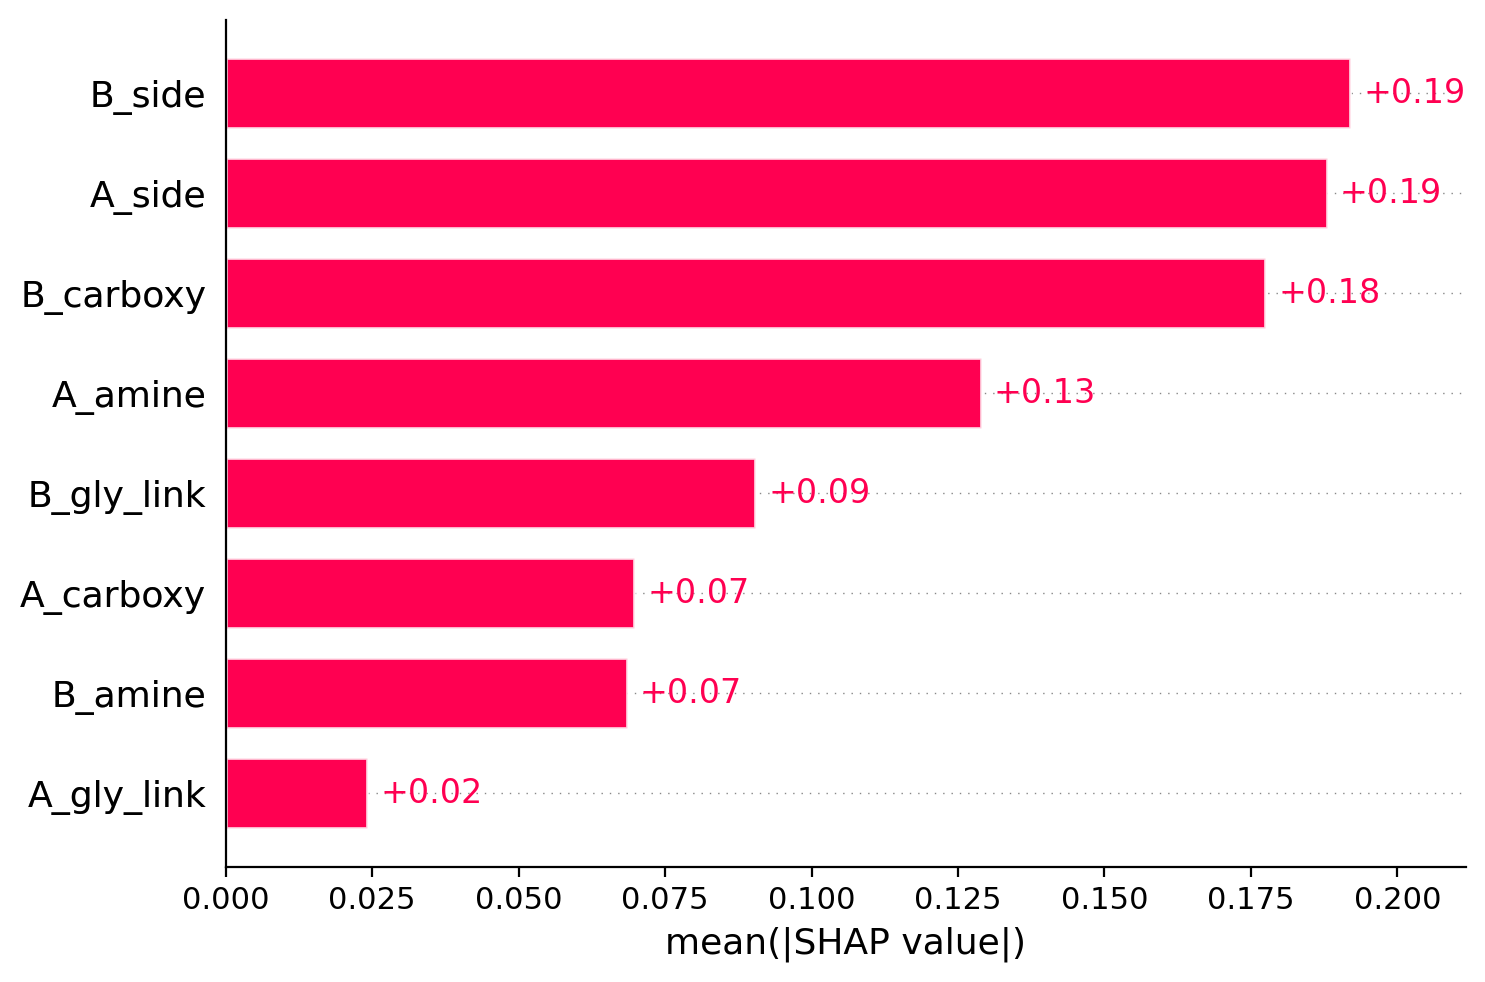

In [123]:
shap.plots.bar(shap_values)


In [124]:
shap.plots.force(shap_values,feature_names=sitelist)

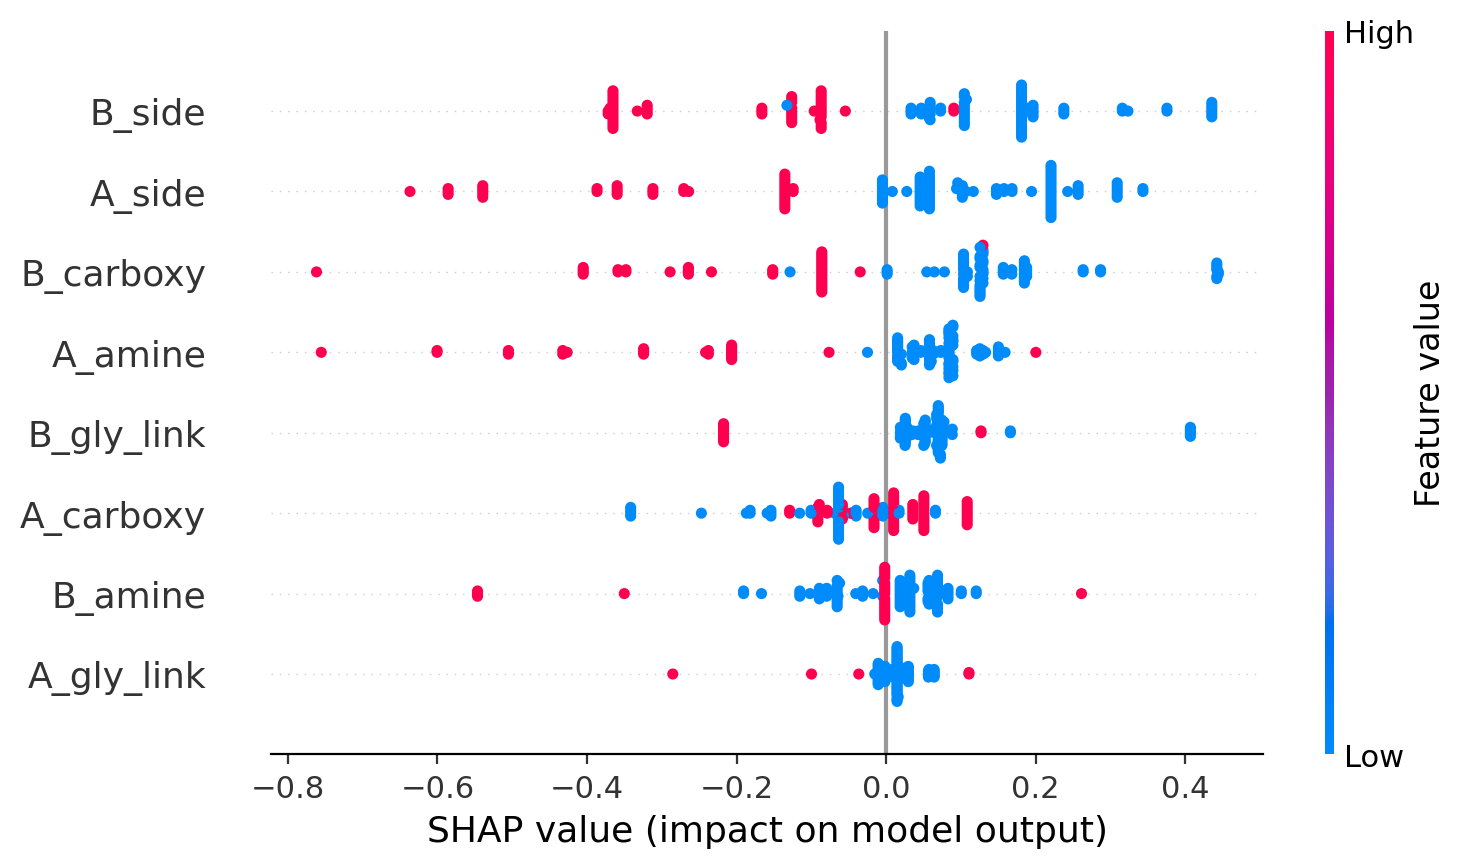

In [125]:
# visualize the first prediction's explanation
shap.plots.beeswarm(shap_values)

In [126]:
inter_df.iloc[52]

A_carboxy     1
A_amine       0
B_carboxy     1
B_amine       0
A_gly_link    0
B_gly_link    0
A_side        0
B_side        0
Name: Asparagine-Methionine, dtype: int64

In [127]:
shap.plots.force(shap_values[52])

In [128]:
np.argmax(y_test)

105

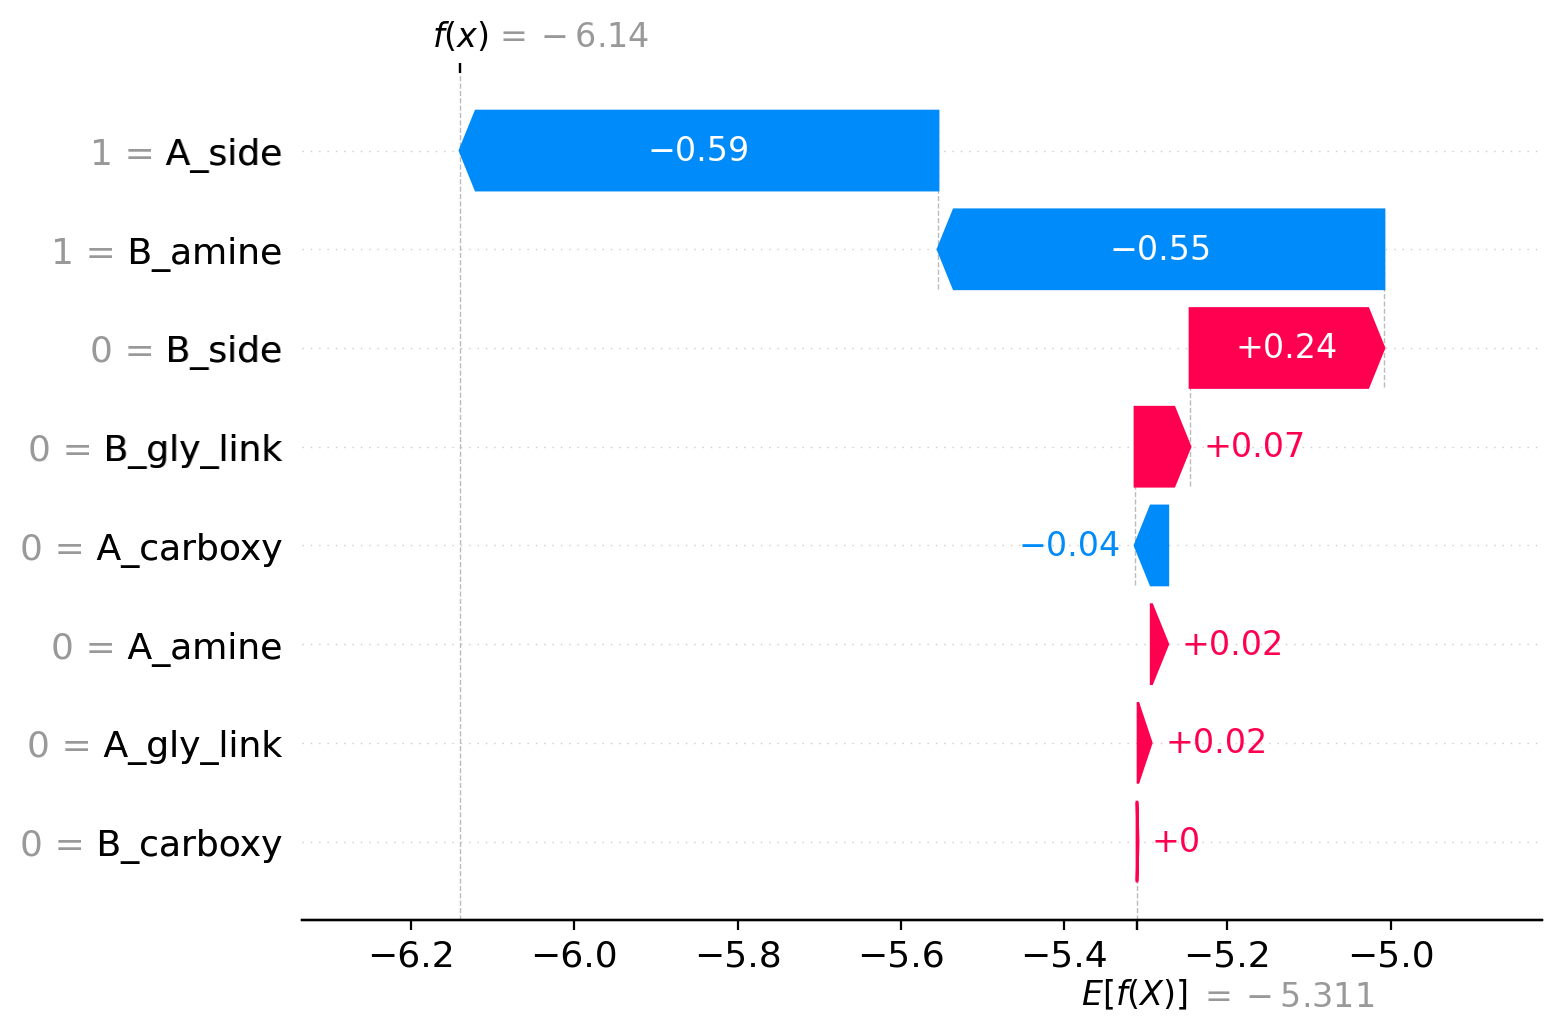

In [129]:
shap.plots.waterfall(shap_values[np.argmin(y_test)])


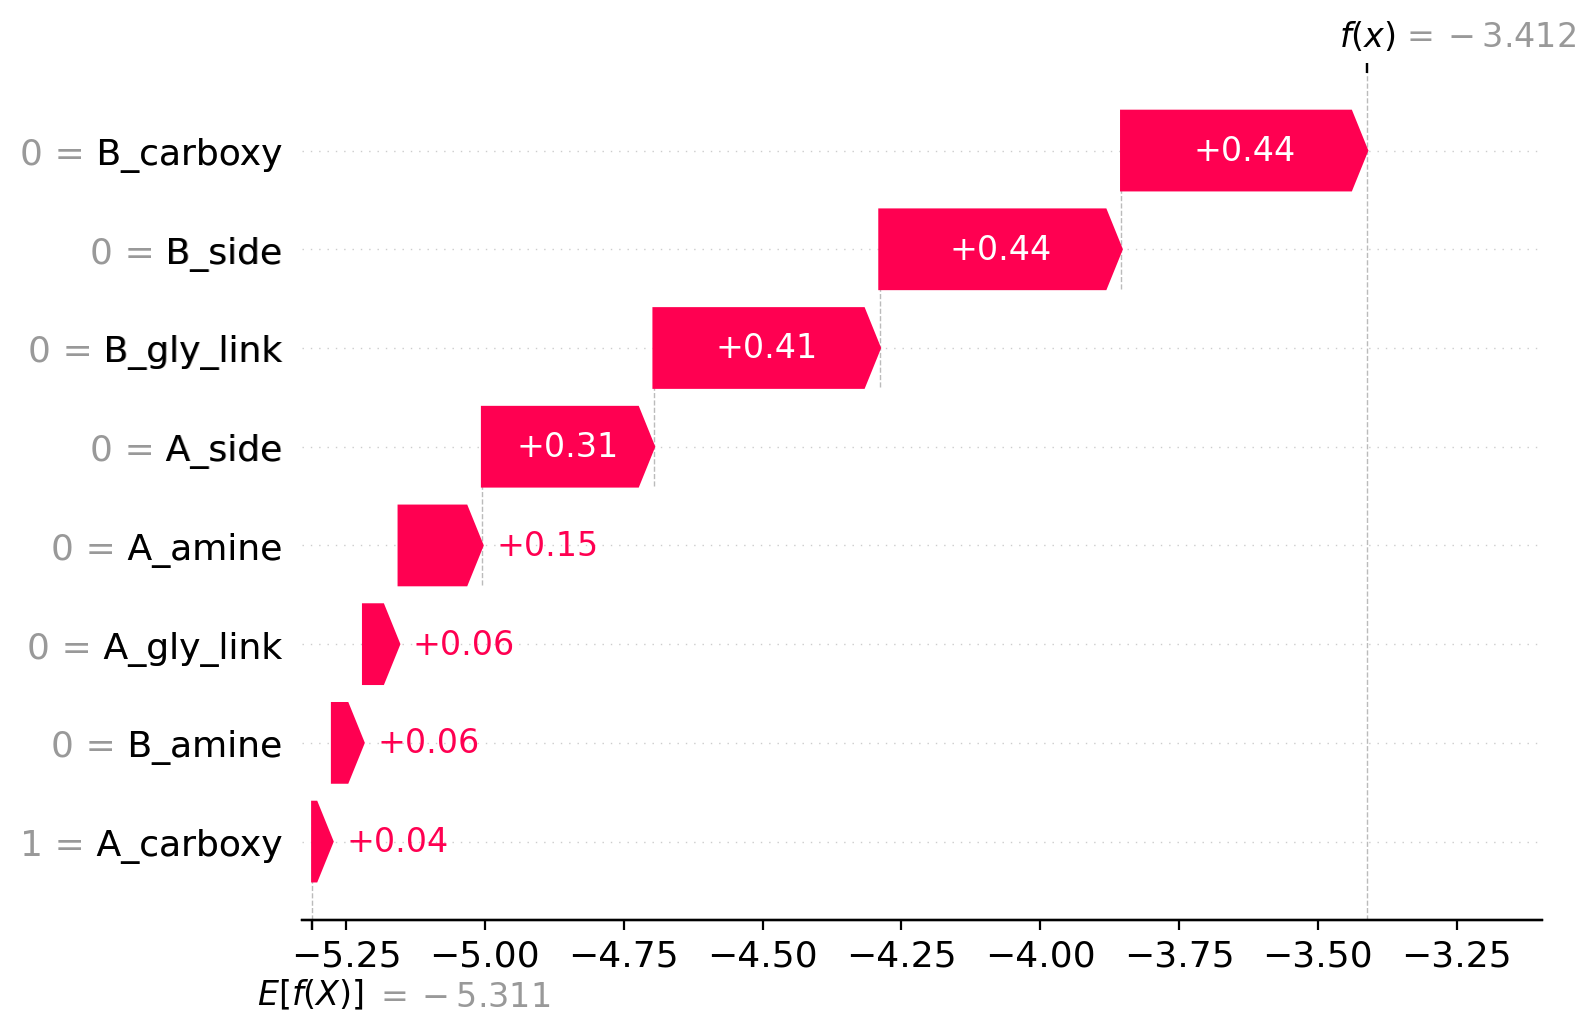

In [130]:
shap.plots.waterfall(shap_values[np.argmax(y_test)])
